In [1]:
import warnings

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.special import expit, softmax

warnings.filterwarnings("ignore", category=FutureWarning)
# rc = {
#     "stats.information_criterion": "waic",
#     'stats.ic_scale': 'deviance',
#     'stats.hdi_prob': 0.89
# }
# az.rcParams.update(rc)
#config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
data = pd.read_csv('Data/chimpanzees.csv', sep=';')
print(data.head())

   actor  recipient  condition  block  trial  prosoc_left  chose_prosoc  \
0      1        NaN          0      1      2            0             1   
1      1        NaN          0      1      4            0             0   
2      1        NaN          0      1      6            1             0   
3      1        NaN          0      1      8            0             1   
4      1        NaN          0      1     10            1             1   

   pulled_left  
0            0  
1            1  
2            0  
3            0  
4            1  


In [3]:
data.groupby('actor').count()

,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
actor,,,,,,,
1,36,72,72,72,72,72,72
2,36,72,72,72,72,72,72
3,36,72,72,72,72,72,72
4,36,72,72,72,72,72,72
5,36,72,72,72,72,72,72
6,36,72,72,72,72,72,72
7,36,72,72,72,72,72,72


We are going to focus on `pulled_left` as the outcome to predict, with `prosoc_left` and `condition` as predictor variables. The outcome `pulled_left` is 0 or 1 indicator that the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two pieces of food.

There are 4 combinations

(1) prosoc_left = 0 and condition = 0: Two food items on right and no partner.

(2) prosoc_left = 1 and condition = 0: Two food items on left and no partner.

(3) prosoc_left = 0 and condition = 1: Two food items on right and partner present.

(4) prosoc_left = 1 and condition = 1: Two food items on left and partner present.

In [4]:
data['treatment'] = data['prosoc_left'] + 2*data['condition']
data.groupby('treatment').first()[['condition', 'pulled_left', 'actor']]

,condition,pulled_left,actor
treatment,,,
0,0,0,1
1,0,0,1
2,1,1,1
3,1,0,1


In [5]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0, 10)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=data.pulled_left)
    prior11_1 = pm.sample_prior_predictive()
    trace11_1 = pm.sample()
    
with pm.Model() as m11_2:
    a = pm.Normal('a', 0, 1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=data.pulled_left)
    prior11_2 = pm.sample_prior_predictive()
    trace11_2 = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


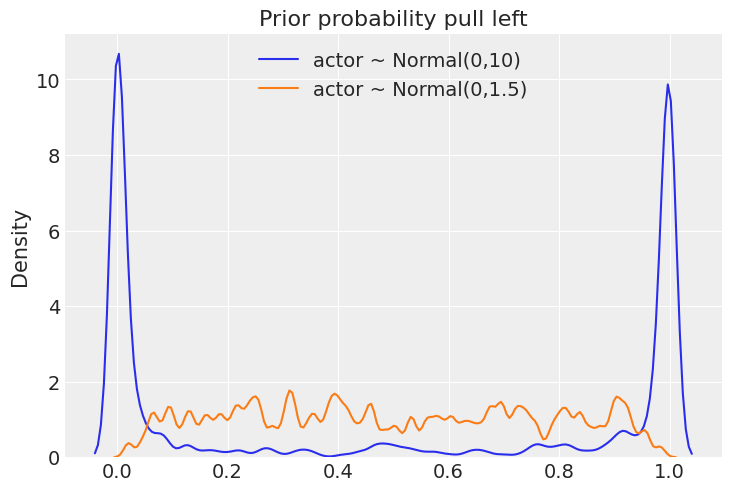

In [6]:
sns.kdeplot(expit(prior11_1['a']), bw_adjust=0.1, label='actor ~ Normal(0,10)')
sns.kdeplot(expit(prior11_2['a']), bw_adjust=0.1, label='actor ~ Normal(0,1.5)')
plt.legend()
plt.title('Prior probability pull left');

In [7]:
with pm.Model() as m11_3:
    a = pm.Normal('a', 0, 1.5)
    b = pm.Normal('b', 0, 10, shape=4)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[data.treatment]))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=data.pulled_left)
    prior11_3 = pm.sample_prior_predictive()
    trace11_3 = pm.sample()
    
with pm.Model() as m11_4:
    a = pm.Normal('a', 0, 1.5)
    b = pm.Normal('b', 0, 0.5, shape=4)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[data.treatment]))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=data.pulled_left)
    prior11_4 = pm.sample_prior_predictive()
    trace11_4 = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8886319367222177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921495130223431, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


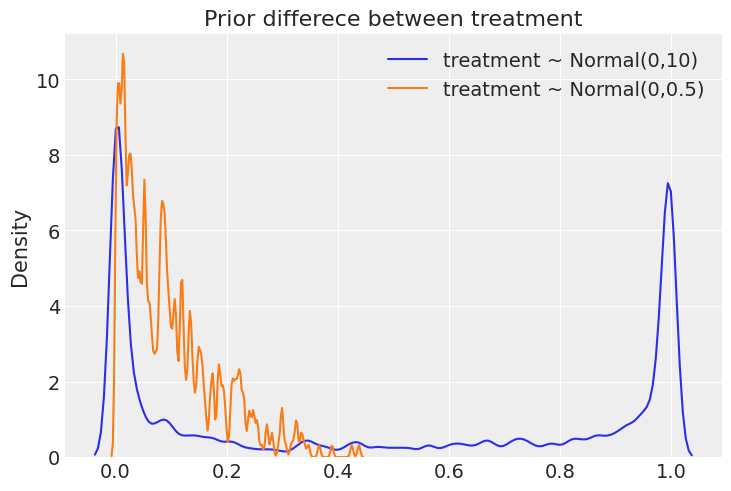

In [8]:
p11_3 = expit(prior11_3['a'].reshape(500,1) + prior11_3['b'])
p11_4 = expit(prior11_4['a'].reshape(500,1) + prior11_4['b'])

sns.kdeplot(np.abs(p11_3[:,0] - p11_3[:,1]), bw_adjust=0.1, label='treatment ~ Normal(0,10)')
sns.kdeplot(np.abs(p11_4[:,0] - p11_4[:,1]), bw_adjust=0.1, label='treatment ~ Normal(0,0.5)')
plt.legend()
plt.title('Prior differece between treatment');

I flat prior for treatment on the logit scale piles up nearly all of the prior probability on zero and one -- the model believes, before it sees that data, that the treatment are either completely alike or completely different. The prior using Normal(0, 0.5) concentrated on low absolute differences. Why a difference of zero has the highest prior probability, the average prior difference is 10%. Extremely large differences are less plausible.

In [9]:
np.abs(p11_4[:,0] - p11_4[:,1]).mean()

0.09461562135702407

In [10]:
actor_ids, actors = pd.factorize(data.actor)
treatment_ids, treatments = pd.factorize(data.treatment)

In [11]:
with pm.Model() as m11_5:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))
    p = pm.Deterministic('p', pm.math.invlogit(a[actor_ids] + b[treatment_ids]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)
    trace11_5 = pm.sample()
idata11_5 = az.from_pymc3(trace11_5)
az.summary(idata11_5, var_names=["a", "b"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.44,0.34,-1.06,0.20,0.01,0.01,1223.60,1798.14,1.01
a[1],3.88,0.76,2.56,5.35,0.02,0.01,2492.68,2048.90,1.00
a[2],-0.75,0.35,-1.40,-0.09,0.01,0.01,1069.31,1756.66,1.01
a[3],-0.74,0.35,-1.37,-0.08,0.01,0.01,1224.22,2056.87,1.01
a[4],-0.44,0.34,-1.08,0.18,0.01,0.01,1275.79,2079.17,1.01
a[5],0.49,0.35,-0.17,1.15,0.01,0.01,1362.70,2209.05,1.01
a[6],1.96,0.43,1.16,2.73,0.01,0.01,1830.00,2073.72,1.00
b[0],-0.05,0.30,-0.61,0.54,0.01,0.01,1120.98,1857.90,1.01
b[1],0.48,0.30,-0.09,1.03,0.01,0.01,1023.12,2109.12,1.01
b[2],-0.39,0.30,-0.99,0.14,0.01,0.01,1129.32,1864.83,1.01


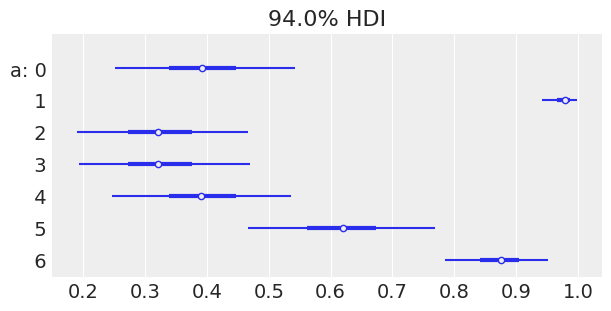

In [12]:
az.plot_forest(idata11_5, var_names=["a"], transform=expit, combined=True, figsize=(6,3));

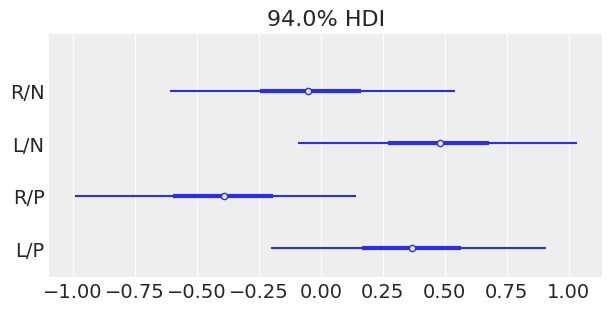

In [13]:
ax = az.plot_forest(idata11_5, var_names=["b"], combined=True, figsize=(6,3))
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

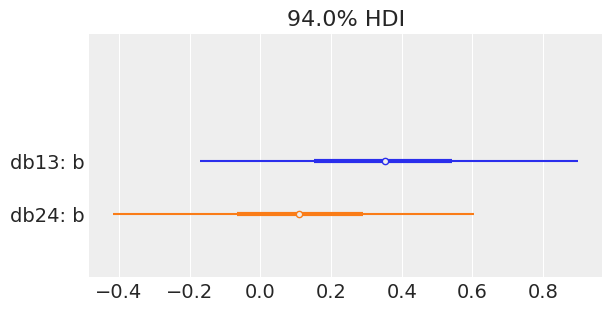

In [14]:
db13 = idata11_5.posterior['b'].sel(b_dim_0=0) - idata11_5.posterior['b'].sel(b_dim_0=2)
db24 = idata11_5.posterior['b'].sel(b_dim_0=1) - idata11_5.posterior['b'].sel(b_dim_0=3)
az.plot_forest([db13, db24], model_names=['db13', 'db24'], combined=True, figsize=(6,3))

In [15]:
side = data.prosoc_left.values
cond = data.condition.values

In [16]:
with pm.Model() as m11_6:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    bs = pm.Normal("bs", 0.0, 0.5, shape=len(side))
    bc = pm.Normal("bc", 0.0, 0.5, shape=len(cond))
    p = pm.Deterministic('p', pm.math.invlogit(a[actor_ids] + bs[side] + bc[cond]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)
    trace11_6 = pm.sample()
idata11_6 = az.from_pymc3(trace11_6)
az.summary(idata11_6, var_names=["a", "bs", "bc"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bc, bs, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.64,0.44,-1.47,0.17,0.01,0.01,2631.06,3126.25,1.0
a[1],3.75,0.82,2.27,5.27,0.01,0.01,5737.00,3072.90,1.0
a[2],-0.95,0.45,-1.78,-0.10,0.01,0.01,2603.94,3391.95,1.0
a[3],-0.94,0.44,-1.76,-0.09,0.01,0.01,2716.97,3051.94,1.0
a[4],-0.65,0.44,-1.43,0.25,0.01,0.01,2509.97,3134.27,1.0
...,...,...,...,...,...,...,...,...,...
bc[499],0.00,0.51,-0.98,0.93,0.00,0.01,10775.14,2079.26,1.0
bc[500],-0.01,0.50,-0.93,0.95,0.00,0.01,10100.68,2802.38,1.0
bc[501],-0.00,0.49,-0.89,0.91,0.00,0.01,11895.42,2639.92,1.0
bc[502],0.00,0.50,-0.90,0.97,0.00,0.01,11315.46,2422.82,1.0


In [17]:
az.compare({'m11_5': trace11_5, 'm11_6': trace11_6}, scale='deviance')

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11_6,0,530.801745,7.772132,0.000000,1.0,19.104969,0.000000,False,deviance
m11_5,1,531.973808,8.342491,1.172062,0.0,18.942532,1.271504,False,deviance


In [18]:
UCBadmit = pd.read_csv('Data/UCBadmit.csv', sep=';')
UCBadmit

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [19]:
UCBadmit.applications.sum()

4526

In [20]:
gender_id, gender = pd.factorize(UCBadmit['applicant.gender'])
print(gender)

Index(['male', 'female'], dtype='object')


In [21]:
with pm.Model() as m11_7:
    a = pm.Normal('a', 0, 1.5, shape=len(gender))
    p = pm.math.invlogit(a[gender_id])
    admit = pm.Binomial('admit', UCBadmit.applications, p, observed=UCBadmit.admit)
    trace11_7 = pm.sample()
az.summary(trace11_7, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
a[0],-0.22,0.04,-0.29,-0.15
a[1],-0.83,0.05,-0.93,-0.74


In [22]:
diffa = trace11_7['a'][:, 0] - trace11_7['a'][:, 1]
diffp = expit(trace11_7['a'][:, 0]) - expit(trace11_7['a'][:, 1])
az.summary({'diffa': diffa, 'diffp': diffp}, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
diffa,0.61,0.06,0.48,0.72
diffp,0.14,0.01,0.11,0.17


In [23]:
dept_id, dept = pd.factorize(UCBadmit.dept)
print(dept_id, dept)

[0 0 1 1 2 2 3 3 4 4 5 5] Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')


In [24]:
with pm.Model() as m11_8:
    a = pm.Normal('a', 0, 1.5, shape=len(gender))
    b = pm.Normal('b', 0, 1.5, shape=len(dept))
    p = pm.math.invlogit(a[gender_id] + b[dept_id])
    admit = pm.Binomial('admit', UCBadmit.applications, p, observed=UCBadmit.admit)
    trace11_8 = pm.sample()
az.summary(trace11_8, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%
a[0],-0.53,0.52,-1.48,0.45
a[1],-0.43,0.52,-1.41,0.53
b[0],1.11,0.53,0.12,2.07
b[1],1.06,0.53,0.13,2.08
b[2],-0.15,0.53,-1.15,0.80
b[3],-0.19,0.53,-1.18,0.78
b[4],-0.63,0.53,-1.59,0.38
b[5],-2.19,0.54,-3.16,-1.14


In [25]:
diffa = trace11_8['a'][:, 0] - trace11_8['a'][:, 1]
diffp = expit(trace11_8['a'][:, 0]) - expit(trace11_8['a'][:, 1])
az.summary({'diffa': diffa, 'diffp': diffp}, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
diffa,-0.10,0.08,-0.25,0.06
diffp,-0.02,0.02,-0.06,0.01


In [26]:
d = UCBadmit[['dept', 'applicant.gender', 'applications']]
pg = d.groupby(['dept', 'applicant.gender']).sum()
pg = pg / d.groupby(['dept']).sum()
pg.T.round(2)

dept                  A            B            C            D            E  \
applicant.gender female  male female  male female  male female  male female   
applications       0.12  0.88   0.04  0.96   0.65  0.35   0.47  0.53   0.67   

dept                        F        
applicant.gender  male female  male  
applications      0.33   0.48  0.52

### Oceanic tool complexity. 

The island societies of Oceania provide a natu-
ral experiment in technological evolution. Different historical island populations possessed
tool kits of different size. These kits include fish hooks, axes, boats, hand plows, and many
other types of tools. A number of theories predict that larger populations will both develop
and sustain more complex tool kits. So the natural variation in population size induced by
natural variation in island size in Oceania provides a natural experiment to test these ideas.
It’s also suggested that contact rates among populations effectively increase population size,
as it’s relevant to technological evolution. So variation in contact rates among Oceanic soci-
eties is also relevant.

The total_tools variable will be the outcome variable. We’ll model the idea that:

(1) The number of tools increases with the log population size. Why log? Because
that’s what the theory says, that it is the order of magnitude of the population that
matters, not the absolute size of it. So we’ll look for a positive association between
total_tools and log population . You can get some intuition for why a linear
impact of population size can’t be right by thinking about mechanism. We’ll think
about mechanism more at the end.

(2) The number of tools increases with the contact rate among islands. No nation is
an island, even when it is an island. Islands that are better networked may acquire
or sustain more tool types.

(3) The impact of population on tool counts is moderated by high contact . This
is to say that the association between total_tools and log population depends
upon contact . So we will look for a positive interaction between log population
and contact rate.

The model that confroms to the research hypothesis includes an interaction between log-population and contact rate.

$$
T_i \sim \text{Poisson}(\lambda_i) \\
\text{log}(\lambda_i) = \alpha_{CID[i]} + \beta_{CID[i]} \text{log}(P_i)
$$

In [27]:
dkline = pd.read_csv('Data/Kline2.csv')
print(dkline.head())
dkline.describe()

      culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   

     logpop  
0  7.003065  
1  7.313220  
2  8.188689  
3  8.474494  
4  8.909235  


,population,total_tools,mean_TU,lat,lon,lon2,logpop
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,34109.100000,34.800000,4.830000,-5.220000,93.710000,-14.29000,8.977005
std,84793.026871,17.849992,1.143144,13.510638,137.161968,19.89486,1.528440
min,1100.000000,13.000000,3.200000,-21.200000,-175.200000,-41.90000,7.003065
25%,3897.750000,22.500000,4.000000,-15.300000,140.300000,-28.92500,8.260140
50%,7700.000000,30.500000,4.850000,-9.700000,151.250000,-13.25000,8.948216
75%,12050.000000,42.250000,5.300000,5.025000,167.125000,-4.22500,9.386268
max,275000.000000,71.000000,6.600000,19.900000,178.100000,24.40000,12.524526


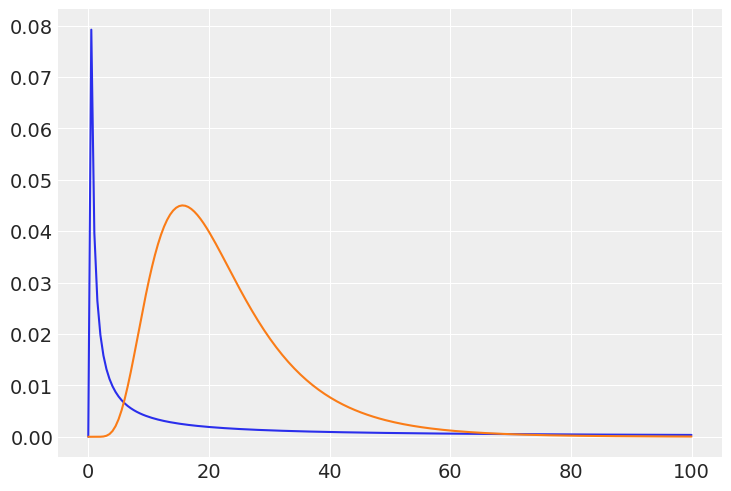

In [28]:
x = np.linspace(0, 100, 200)
plt.plot(x, stats.lognorm.pdf(x, 10, scale=1))
plt.plot(x, stats.lognorm.pdf(x, 0.5, scale=np.exp(3.0)))

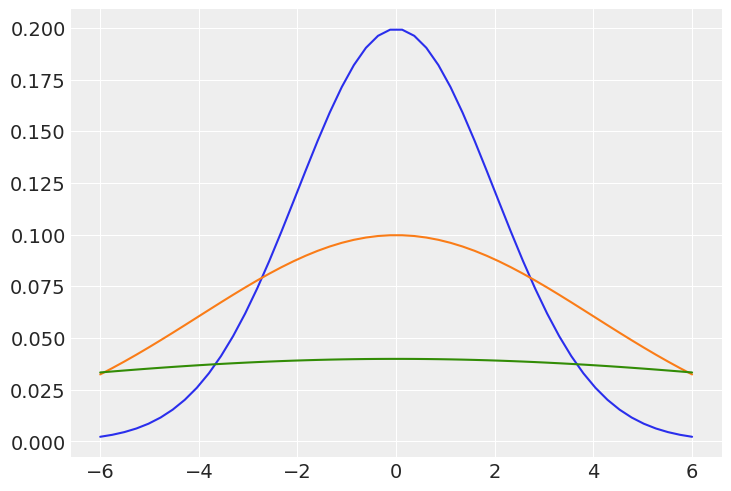

In [29]:
x = np.linspace(-6,6,50)
plt.plot(x, stats.norm.pdf(x, 0, 2))
plt.plot(x, stats.norm.pdf(x, 0, 4))
plt.plot(x, stats.norm.pdf(x, 0, 10))

In [30]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

P = standardize(np.log(dkline.population)).values
c_id, _ = pd.factorize(dkline.contact)

In [31]:
with pm.Model() as m11_9:
    a = pm.Normal('a', 3, 0.5)
    lam = pm.math.exp(a)
    T = pm.Poisson('T', lam, observed=dkline.total_tools)
    trace11_9 = pm.sample()
    
with pm.Model() as m11_10:
    a = pm.Normal('a', 3, 0.5, shape=2)
    b = pm.Normal('b', 0, 0.2, shape=2)    
    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data('P', P)
    lam = pm.math.exp(a[cid] + b[cid]*P_)
    T = pm.Poisson('total_tools', lam, observed=dkline.total_tools)
    trace11_10 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [32]:
az.compare({'m11_9': trace11_9, 'm11_10': trace11_10})

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11_10,0,-42.467986,6.798021,0.000000,0.965065,6.208750,0.000000,True,log
m11_9,1,-70.620918,7.974157,28.152932,0.034935,15.952472,15.775431,False,log


In [33]:
k = az.loo(trace11_10, pointwise=True).pareto_k.values

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [34]:
ns = 100
P_seq = np.linspace(-1.4, 3, ns)
with m11_10:
    pm.set_data({"cid": np.zeros(ns, dtype=int), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace11_10, var_names=['total_tools'])['total_tools']
    
    pm.set_data({"cid": np.ones(ns, dtype=int), "P": P_seq})
    lam1 = pm.sample_posterior_predictive(trace11_10, var_names=['total_tools'])['total_tools']
    
lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

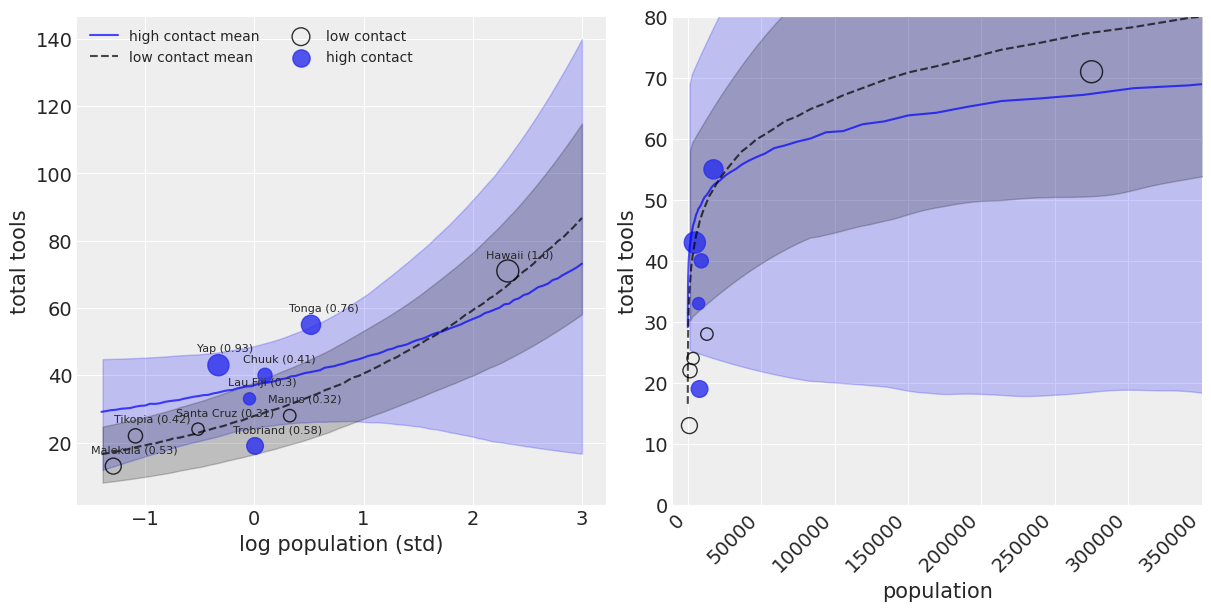

In [35]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
# scale point size to Pareto-k:
k /= k.max()
psize = 250 * k

az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")
az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display names and k:
mask = k > 0.3
labels = dkline.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(
        P[mask][i] - 0.2,
        dkline.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k[mask][i], 2)})",
        fontsize=8,
    )
# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dkline.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(P[index], dkline.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=10, ncol=2)

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(P_seq * np.log(dkline.population.values).std() + np.log(dkline.population.values).mean())

az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dkline.population[~index],
    dkline.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dkline.population[index], dkline.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_ylim((0, 80))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools");

In [36]:
P = standardize(np.log(dkline.population)).values
P = P + np.abs(P.min()) + 0.1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8806694724645797, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


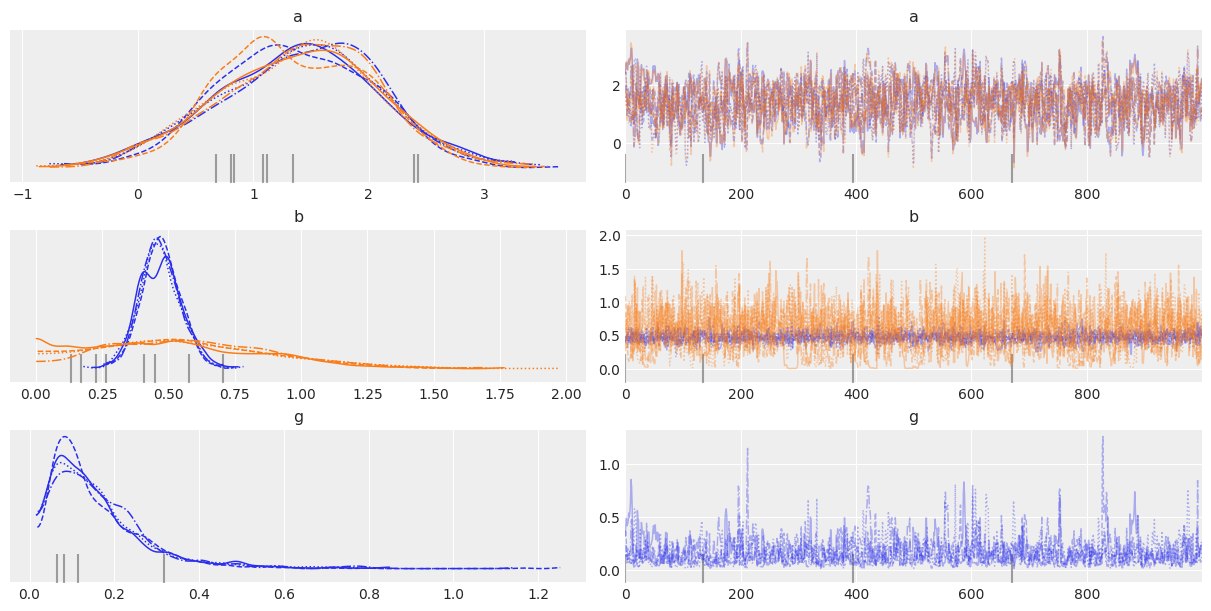

In [37]:
with pm.Model() as m11_11:    
    a = pm.Normal("a", 1, 1, shape=2)
    b = pm.Exponential("b", 1, shape=2)
    g = pm.Exponential("g", 1)
    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = pm.math.exp(a[cid])*P**b[cid]/g
    T = pm.Poisson("total_tools", lam, observed=dkline.total_tools)
    trace11_11 = pm.sample()
az.plot_trace(trace11_11, compact=True);

In [39]:
y = np.random.poisson(1.5, size=30)
y_new = np.random.poisson(0.5*7, size=4)
y_all = np.hstack([y, y_new])
exposure = np.repeat((1, 7), (30, 4))
monastery = np.repeat((0, 1), (30, 4))
y_all, exposure, monastery

(array([2, 0, 1, 2, 2, 2, 2, 1, 1, 4, 0, 2, 1, 1, 0, 1, 1, 3, 4, 3, 1, 1,
        0, 3, 1, 2, 3, 1, 4, 6, 7, 3, 2, 6]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]))

In [40]:
log_days = np.log(exposure)

with pm.Model() as m11_12:
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1)
    lam = pm.math.exp(a + b*monastery + log_days)
    y = pm.Poisson("y", lam, observed=y_all)
    trace11_12 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [41]:
lam_old = np.exp(trace11_12['a'])
lam_new = np.exp(trace11_12['a'] + trace11_12['b'])
az.summary({"lam_old": lam_old, "lam_new": lam_new}, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
lam_old,1.79,0.25,1.33,2.25
lam_new,0.67,0.16,0.40,0.98


In [42]:
N = 500
income = np.array([1,2,5])
score = 0.5*income
p = softmax(score)
career = np.random.multinomial(1, p, size=N)
career = np.where(career == 1)[1]
career

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,